<a href="https://colab.research.google.com/github/yblee110/jax-flax-book/blob/main/ch03_1_Flax_%ED%8A%9C%ED%86%A0%EB%A6%AC%EC%96%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
import flax
import optax


print("JAX Version : {}".format(jax.__version__))
print("FLAX Version : {}".format(flax.__version__))
print("OPTAX Version : {}".format(optax.__version__))

JAX Version : 0.4.26
FLAX Version : 0.8.4
OPTAX Version : 0.2.2


In [2]:
!pip install datasets

import jax.numpy as jnp
from datasets import load_dataset


def get_datasets():
    datasets = load_dataset("mnist")
    datasets = datasets.with_format("jax")
    datasets = {
        "train": {
            "image": datasets["train"]["image"][..., None].astype(jnp.float32)/255,
            "label": datasets["train"]["label"],
        },
        "test": {
            "image": datasets["test"]["image"][..., None].astype(jnp.float32)/255,
            "label": datasets["test"]["label"],
        },
    }
    return datasets['train'], datasets['test']

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4

In [3]:
train_ds, test_ds = get_datasets()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for mnist contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mnist.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [4]:
from flax import linen as nn


class CNN(nn.Module):
    num_classes: int

    def setup(self):
        self.conv1 = nn.Conv(features=16, kernel_size=(5, 5), strides=(2, 2), padding='VALID')
        self.conv2 = nn.Conv(features=16, kernel_size=(5, 5), strides=(2, 2), padding='VALID')
        self.dense1 = nn.Dense(features=self.num_classes)

    def __call__(self, x,):
        x = self.conv1(x)
        x = nn.relu(x)
        x = self.conv2(x)
        x = nn.relu(x)
        x = jnp.mean(x, axis=(1, 2))
        x = self.dense1(x)
        return x

In [5]:
from flax import linen as nn


class CNN(nn.Module):
   num_classes: int


   @nn.compact
   def __call__(self, x,):
       x = nn.Conv(features=16, kernel_size=(5, 5), strides=(2, 2), padding='VALID')(x)
       x = nn.relu(x)
       x = nn.Conv(features=32, kernel_size=(5, 5), strides=(2, 2), padding='VALID')(x)
       x = nn.relu(x)
       x = jnp.mean(x, axis=(1, 2))
       x = nn.Dense(features=self.num_classes)(x)
       return x

In [6]:
rng = jax.random.PRNGKey(0)
model = CNN(num_classes=10)
rng, key = jax.random.split(rng)
variables = model.init(key, jnp.ones((1, 28, 28, 1)))
params = variables['params']

In [7]:
print(model.tabulate(key, jnp.ones((1, 28, 28, 1))))


                                         CNN Summary                                         
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs              ┃ outputs             ┃ params                     ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ CNN    │ float32[1,28,28,1]  │ float32[1,10]       │                            │
├─────────┼────────┼─────────────────────┼─────────────────────┼────────────────────────────┤
│ Conv_0  │ Conv   │ float32[1,28,28,1]  │ float32[1,12,12,16] │ bias: float32[16]          │
│         │        │                     │                     │ kernel: float32[5,5,1,16]  │
│         │        │                     │                     │                            │
│         │        │                     │                     │ 416 (1.7 KB)               │
├─────────┼────────┼─────────────────────┼─────────────────

In [8]:
def compute_metrics(logits, labels):
    loss = jnp.mean(optax.softmax_cross_entropy(logits,
                    jax.nn.one_hot(labels, num_classes=10)))
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
        'loss': loss,
        'accuracy': accuracy
    }
    return metrics

In [9]:
from flax.training.train_state import TrainState


learning_rate = 0.001
tx = optax.adam(learning_rate=learning_rate)


state = TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=tx,
)

In [10]:
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch['image'])
        loss = jnp.mean(optax.softmax_cross_entropy(
            logits=logits,
            labels=jax.nn.one_hot(batch['label'], num_classes=10))
        )
        return loss, logits
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)


    metrics = compute_metrics(logits, batch['label'])
    return state, metrics



In [11]:
@jax.jit
def eval_step(state, batch):
    logits = state.apply_fn({'params': state.params}, batch['image'])
    return compute_metrics(logits, batch['label'])

In [12]:
def train_loop(state, train_ds, batch_size, epoch, rng):
    train_ds_size = len(train_ds['image'])
    steps_per_epoch = train_ds_size // batch_size


    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size]  # Skip an incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))

    batch_metrics = []
    for perm in perms:
        batch = {k: v[perm, ...] for k, v in train_ds.items()}
        state, metrics = train_step(state, batch)
        batch_metrics.append(metrics)


    training_batch_metrics = jax.device_get(batch_metrics)
    training_epoch_metrics = {
        k: sum([metrics[k] for metrics in training_batch_metrics])/steps_per_epoch
        for k in training_batch_metrics[0]}


    print('EPOCH: %d\nTraining loss: %.4f, accuracy: %.2f' % (epoch, training_epoch_metrics['loss'], training_epoch_metrics['accuracy'] * 100))
    return state


In [13]:
def eval_loop(state, test_ds, batch_size):
    eval_ds_size = test_ds['image'].shape[0]
    steps_per_epoch = eval_ds_size // batch_size


    batch_metrics = []
    for i in range(steps_per_epoch):
        batch = {k: v[i*batch_size:(i+1)*batch_size, ...] for k, v in test_ds.items()}
        metrics = eval_step(state, batch)
        batch_metrics.append(metrics)


    eval_batch_metrics = jax.device_get(batch_metrics)
    eval_batch_metrics = {
        k: sum([metrics[k] for metrics in eval_batch_metrics])/steps_per_epoch
        for k in eval_batch_metrics[0]}
    print('    Eval loss: %.4f, accuracy: %.2f' % (eval_batch_metrics['loss'], eval_batch_metrics['accuracy'] * 100))


In [14]:
train_epoch = 10
batch_size = 64
eval_batch_size = 100

for epoch in range(train_epoch):
    rng, key = jax.random.split(rng)
    state = train_loop(state, train_ds, batch_size, epoch, rng)
    eval_loop(state, test_ds, eval_batch_size)

EPOCH: 0
Training loss: 0.8405, accuracy: 75.84
    Eval loss: 0.3679, accuracy: 89.73
EPOCH: 1
Training loss: 0.3268, accuracy: 90.72
    Eval loss: 0.2363, accuracy: 93.24
EPOCH: 2
Training loss: 0.2485, accuracy: 92.78
    Eval loss: 0.2038, accuracy: 93.91
EPOCH: 3
Training loss: 0.2070, accuracy: 93.99
    Eval loss: 0.1748, accuracy: 94.85
EPOCH: 4
Training loss: 0.1801, accuracy: 94.71
    Eval loss: 0.1450, accuracy: 95.86
EPOCH: 5
Training loss: 0.1633, accuracy: 95.22
    Eval loss: 0.1333, accuracy: 96.08
EPOCH: 6
Training loss: 0.1497, accuracy: 95.56
    Eval loss: 0.1379, accuracy: 95.77
EPOCH: 7
Training loss: 0.1369, accuracy: 95.99
    Eval loss: 0.1318, accuracy: 96.10
EPOCH: 8
Training loss: 0.1297, accuracy: 96.14
    Eval loss: 0.1015, accuracy: 97.03
EPOCH: 9
Training loss: 0.1192, accuracy: 96.49
    Eval loss: 0.1044, accuracy: 96.95


In [15]:
@jax.jit
def pred_step(state, batch):
    logits = state.apply_fn({'params': state.params}, batch)
    return logits.argmax(axis=1)

pred = pred_step(state, test_ds['image'][:25])

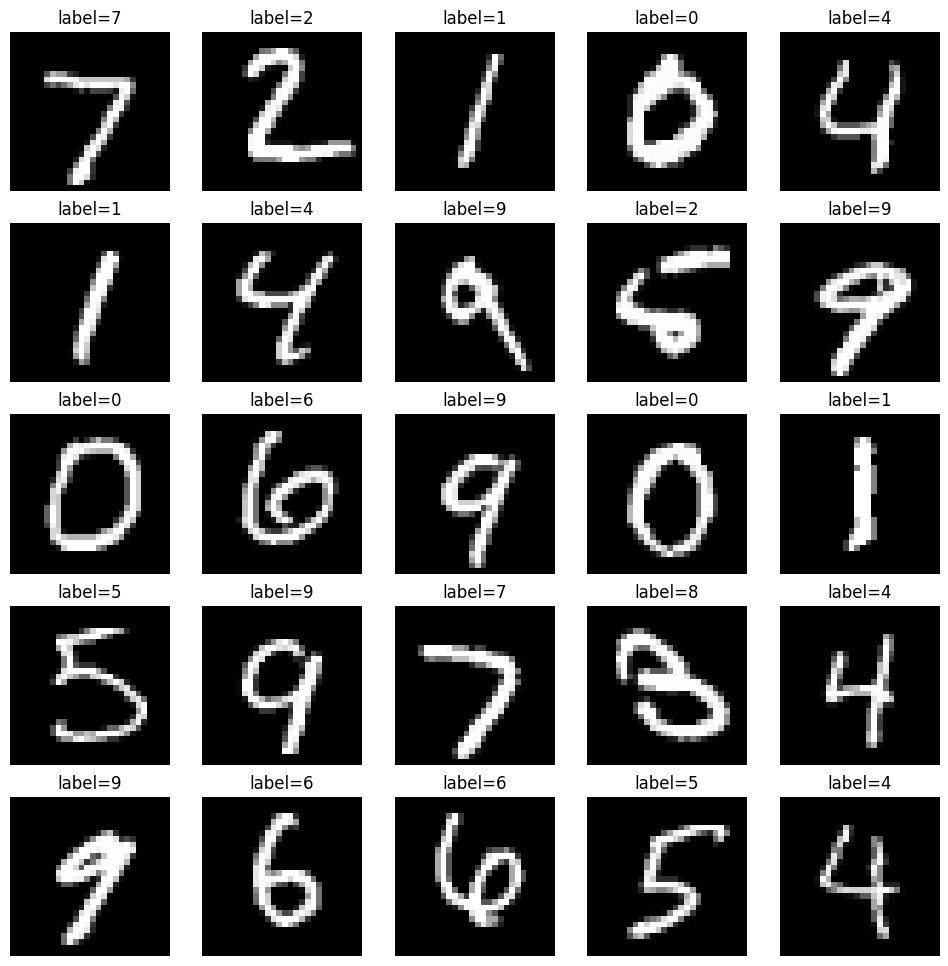

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
   ax.imshow(test_ds['image'][i], cmap='gray')
   ax.set_title(f"label={pred[i]}")
   ax.axis('off')